#Student Result Prediction and Learning Analytics

This project aims to identify the factors for student success in online classes (from The Open University dataset) and predict final result using machine learning.
In this project, we will do the following:

1. Download learning analytics data from OULAD and preview them
2. Perform data cleaning
3. Perform exploratory data analysis
4. Engineer new features
5. Apply machine learning techniques to train a model to predict student dropout
6. Perform hyperparameter tuning to push model performance

##Download learning analytics data from OULAD


Download the dataset from the Open Universiy Learning Analytics Dataset (OULAD) [here](https://analyse.kmi.open.ac.uk/open_dataset/download).

Unzip the files and store it in my own drive. Then use the Python libraries to import each file individually.


In [3]:
# Import library
import pandas as pd

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
folder_path = '/content/drive/My Drive/data/Learning'

assessments = pd.read_csv(folder_path + '/assessments.csv')
courses = pd.read_csv(folder_path + '/courses.csv')
studentAssessment = pd.read_csv(folder_path + '/studentAssessment.csv')
studentInfo = pd.read_csv(folder_path + '/studentInfo.csv')
studentRegistration = pd.read_csv(folder_path + '/studentRegistration.csv')
studentVle = pd.read_csv(folder_path + '/studentVle.csv')
vle = pd.read_csv(folder_path + '/vle.csv')

##Perform Data Cleaning

We inspect the respective dataframes and clean them up along the way.

In [5]:
# Take a peek into studentAssessment - Groupby id_student to get the score's mean, max, min
studentAssessment.groupby(['id_student'])['score'].agg(['mean', 'max', 'min'])

,mean,max,min
id_student,,,
6516,61.800000,77.0,48.0
8462,87.000000,93.0,83.0
11391,82.000000,85.0,78.0
23629,82.500000,100.0,63.0
23698,74.444444,94.0,56.0
...,...,...,...
2698251,58.142857,76.0,36.0
2698257,67.800000,76.0,58.0
2698535,39.250000,62.0,13.0


In [6]:
# Reset index and rename columns
studentAssessment = studentAssessment.groupby(['id_student'])['score'].agg(['mean', 'max', 'min']).reset_index()
studentAssessment.columns = ['id_student', 'mean', 'max', 'min']
studentAssessment

,id_student,mean,max,min
0,6516,61.800000,77.0,48.0
1,8462,87.000000,93.0,83.0
2,11391,82.000000,85.0,78.0
3,23629,82.500000,100.0,63.0
4,23698,74.444444,94.0,56.0
...,...,...,...,...
23364,2698251,58.142857,76.0,36.0
23365,2698257,67.800000,76.0,58.0
23366,2698535,39.250000,62.0,13.0
23367,2698577,64.400000,100.0,54.0


In [7]:
# Take a peek into studentVle - groupby so that you get the sum for sum_clicks per student in each code_presentation and code_module 
studentVle.groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].agg(['sum'])

sum
code_module code_presentation id_student      
AAA         2013J             11391        934
                              28400       1435
                              30268        281
                              31604       2158
                              32885       1034
...                                        ...
GGG         2014J             2640965       41
                              2645731      893
                              2648187      312
                              2679821      275
                              2684003      616

[29228 rows x 1 columns]

In [8]:
# Reset the index of the groupby stundentvle DataFrame
studentVle = studentVle.groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].agg(['sum']).reset_index()
studentVle

,code_module,code_presentation,id_student,sum
0,AAA,2013J,11391,934
1,AAA,2013J,28400,1435
2,AAA,2013J,30268,281
3,AAA,2013J,31604,2158
4,AAA,2013J,32885,1034
...,...,...,...,...
29223,GGG,2014J,2640965,41
29224,GGG,2014J,2645731,893
29225,GGG,2014J,2648187,312
29226,GGG,2014J,2679821,275


In [9]:
# Take a peek into studentInfo 
studentInfo

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


In [10]:
# Assess how many missing values per column
studentInfo.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

In [11]:
# So we replace  the NaN in 'imd_band' column with 'Missing', then double-check the output
studentInfo['imd_band'] = studentInfo['imd_band'].fillna('Missing')
studentInfo.isnull().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64

We notice there are 32,593 rows in studentInfo, but only 23,369 rows from studentAssessment Dataframe.  This implies duplicates in studentInfo, that we should remove. 

In [12]:
# Get number of unique values in id_student 
studentInfo['id_student'].nunique()

28785

In [13]:
# Step 12: Drop duplicates from id_student column
studentInfo = studentInfo.drop_duplicates(subset=['id_student'], keep='last')
studentInfo

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


## Merging DataFrames

We are now going to merge these DataFrames in the following order:

1. studentInfo + studentVle (groupby) = studentInfo_Vle
2. studentInfo_Vle + studentAssessment (groupby) = studentInfo_Vle_Scores

In [14]:
## Merge step 1 - studentInfo + studentVle (groupby)
studentInfo_Vle = pd.merge(studentInfo, studentVle, how='left', on=['code_module', 'code_presentation', 'id_student'])
studentInfo_Vle

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28780,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,41.0
28781,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,893.0
28782,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,312.0
28783,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,275.0


In [15]:
# Count missing values in columns
studentInfo_Vle.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                   0
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
sum                     2855
dtype: int64

In [16]:
# Replace NaN with 0, then check the total number of missing values in all columns again
studentInfo_Vle.fillna(0, inplace=True)
studentInfo_Vle.isnull().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
sum                     0
dtype: int64

In [17]:
# Merge Step 2 - studentInfo_Vle + studentAssessment (groupby)
studentInfo_Vle_Scores = pd.merge(studentInfo_Vle, studentAssessment, how='left', on=['id_student'])
studentInfo_Vle_Scores

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum,mean,max,min
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0,82.000000,85.0,78.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0,66.400000,70.0,60.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0,NaN,NaN,NaN
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0,76.000000,88.0,71.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0,54.400000,75.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28780,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,41.0,NaN,NaN,NaN
28781,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,893.0,88.111111,100.0,72.0
28782,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,312.0,76.666667,100.0,60.0
28783,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,275.0,91.500000,100.0,83.0


In [18]:
# Fill missing data in mean/max/min columns with median
studentInfo_Vle_Scores['mean'].fillna(studentInfo_Vle_Scores['mean'].median(), inplace=True)
studentInfo_Vle_Scores['max'].fillna(studentInfo_Vle_Scores['max'].median(), inplace=True)
studentInfo_Vle_Scores['min'].fillna(studentInfo_Vle_Scores['min'].median(), inplace=True)

In [19]:
# Final Check for missing column data
studentInfo_Vle_Scores.isnull().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
sum                     0
mean                    0
max                     0
min                     0
dtype: int64

##Exploratory Data Analysis

After data import and cleaning, we are now ready to visualise the column data with some Univariate Analysis (UA) and Bivariate Analysis (BA).

In [20]:
# Import all the standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

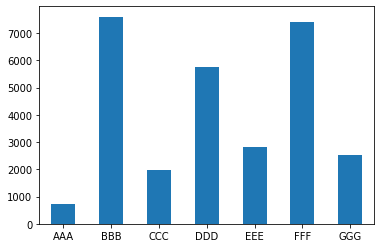

In [21]:
# Perform UA on 'code_module' with a barplot
studentInfo_Vle_Scores['code_module'].value_counts().sort_index().plot.bar(rot=0)

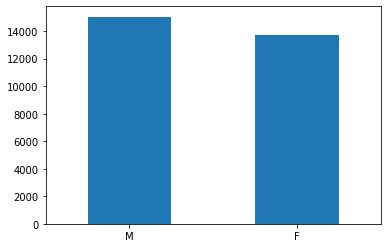

In [22]:
# Perform UA on 'gender' with a barplot
studentInfo_Vle_Scores['gender'].value_counts().plot.bar(rot=0)

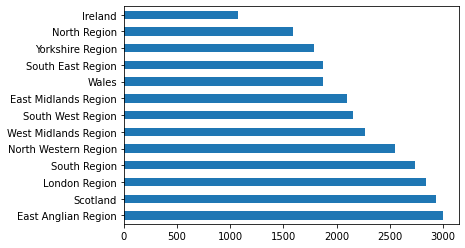

In [23]:
# Perform UA on 'region' with a horizontal barplot
studentInfo_Vle_Scores['region'].value_counts().plot.barh()

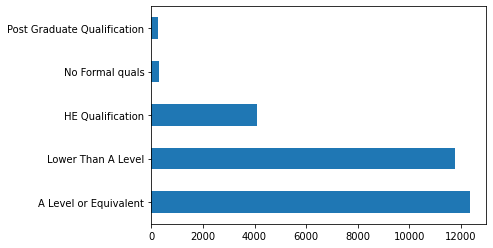

In [24]:
# Perform UA on 'highest_qualification' with a horizontal barplot
studentInfo_Vle_Scores['highest_education'].value_counts().plot.barh()

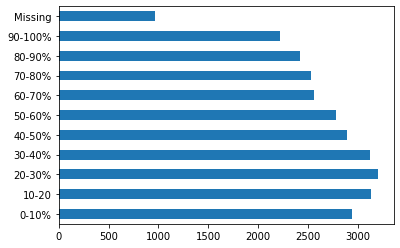

In [25]:
# Perform UA on 'imd_band' with a horizontal barplot
studentInfo_Vle_Scores['imd_band'].value_counts().sort_index().plot.barh()

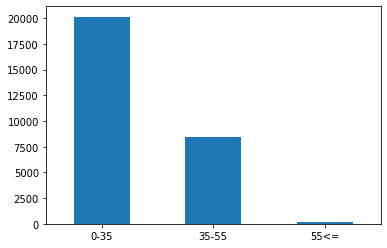

In [27]:
# Perform UA on 'age_band' with a barplot
studentInfo_Vle_Scores['age_band'].value_counts().plot.bar(rot=0)

In [28]:
# Perform UA on the num_of_previous_attempts column by counting number of values
studentInfo_Vle_Scores['num_of_prev_attempts'].value_counts()

0    25006
1     2967
2      627
3      133
4       37
5       11
6        4
Name: num_of_prev_attempts, dtype: int64

(array([2.1415e+04, 6.2260e+03, 8.6600e+02, 2.2400e+02, 3.8000e+01,
        9.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([ 30. ,  92.5, 155. , 217.5, 280. , 342.5, 405. , 467.5, 530. ,
        592.5, 655. ]),
 <a list of 10 Patch objects>)

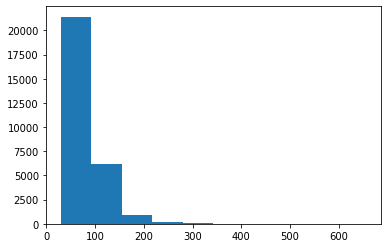

In [29]:
# Perform UA on 'studied_credits' by plotting a histogram
plt.hist(studentInfo_Vle_Scores['studied_credits'], bins=10)

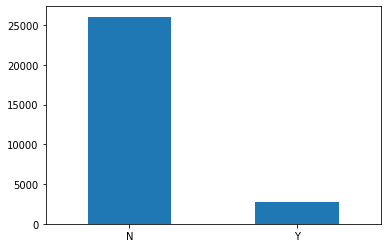

In [30]:
# Perform UA for 'disability' with a barplot
studentInfo_Vle_Scores['disability'].value_counts().plot.bar(rot=0)

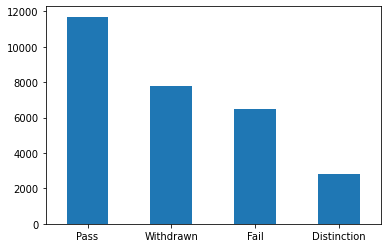

In [31]:
# Perform UA on 'final_result' with a barplot
studentInfo_Vle_Scores['final_result'].value_counts().plot.bar(rot=0)

(array([2.3117e+04, 3.8130e+03, 1.2510e+03, 3.7700e+02, 1.3700e+02,
        3.9000e+01, 2.4000e+01, 1.7000e+01, 4.0000e+00, 6.0000e+00]),
 array([    0. ,  2112.3,  4224.6,  6336.9,  8449.2, 10561.5, 12673.8,
        14786.1, 16898.4, 19010.7, 21123. ]),
 <a list of 10 Patch objects>)

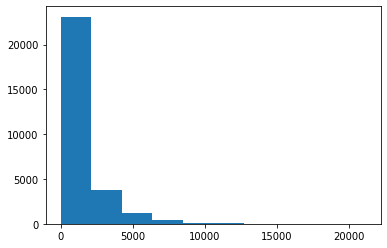

In [32]:
# Perform UA on 'sum' - total number of clicks - with a histogram
plt.hist(studentInfo_Vle_Scores['sum'], bins=10)

(array([  118.,    70.,   168.,   419.,  1058.,  2202.,  4024., 11696.,
         6740.,  2290.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

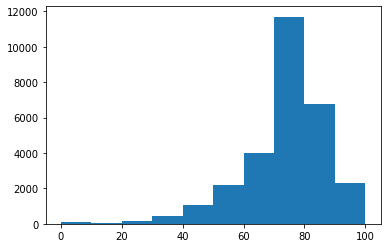

In [33]:
# Perform UA for 'mean' with a histogram
plt.hist(studentInfo_Vle_Scores['mean'], bins=10)

(array([  113.,    53.,    67.,   145.,   354.,   657.,  1370.,  2221.,
         4349., 19456.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

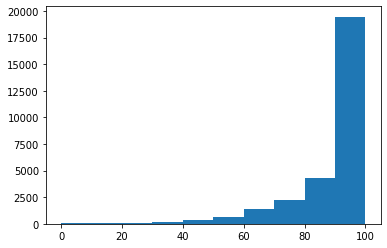

In [34]:
# Perform UA  for 'max' with a histogram
plt.hist(studentInfo_Vle_Scores['max'], bins=10)

(array([1234.,  702., 1335., 1591., 3161., 9098., 5136., 3800., 2170.,
         558.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

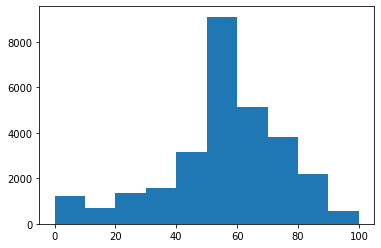

In [35]:
# Perform UA for 'min' with a histogram
plt.hist(studentInfo_Vle_Scores['min'], bins=10)

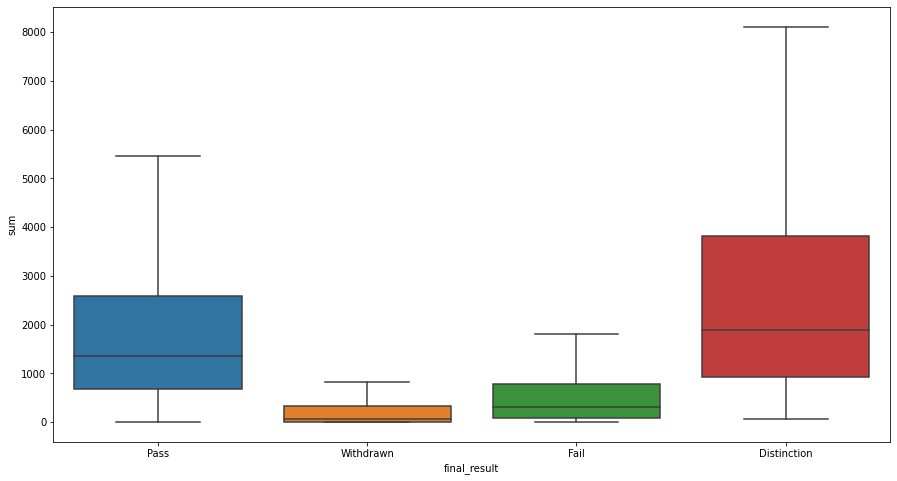

In [36]:
# Perform BA on sum vs final_result with boxplot
plt.figure(figsize=(15,8))
sns.boxplot(x='final_result', y='sum', showfliers=False, data=studentInfo_Vle_Scores)

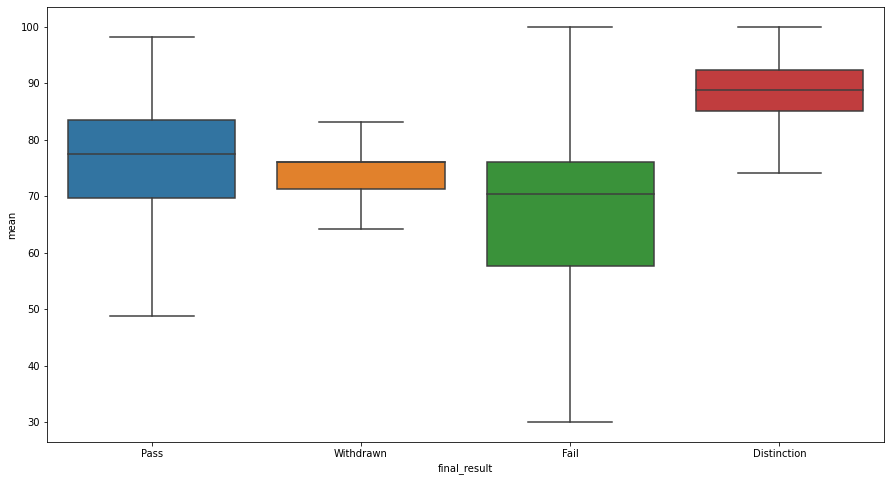

In [37]:
# Perform BA on mean vs final_result with boxplot
plt.figure(figsize=(15,8))
sns.boxplot(x='final_result', y='mean', showfliers=False, data=studentInfo_Vle_Scores)

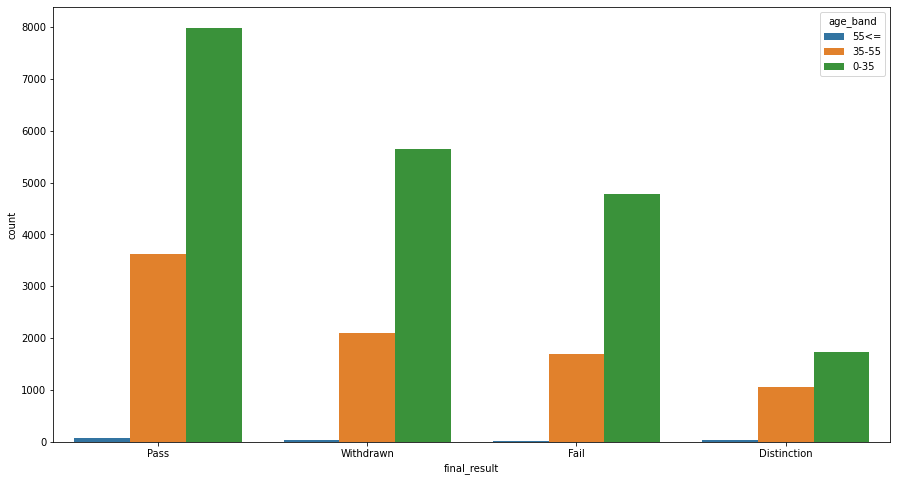

In [38]:
# Perform BA on age_band vs final_result with countplot
plt.figure(figsize=(15,8))
sns.countplot(x='final_result', hue='age_band', data=studentInfo_Vle_Scores)

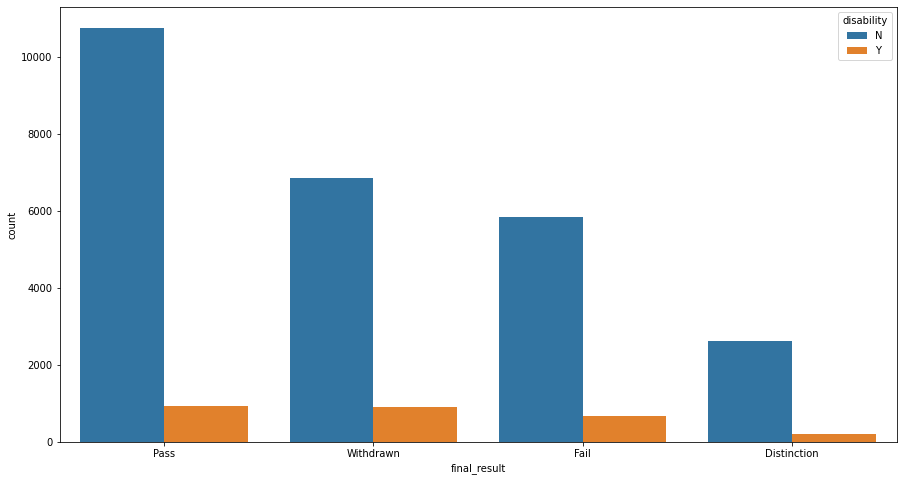

In [39]:
# Perform BA on disability vs final_result with countplot
plt.figure(figsize=(15,8))
sns.countplot(x='final_result', hue='disability', data=studentInfo_Vle_Scores)

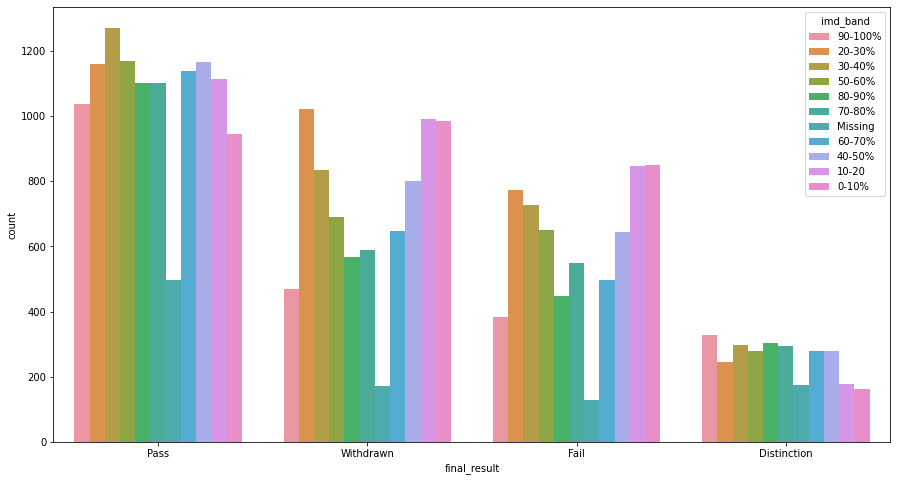

In [40]:
# Perform BA on imd_band vs final_result with a countplot
plt.figure(figsize=(15,8))
sns.countplot(x='final_result', hue='imd_band', data=studentInfo_Vle_Scores)

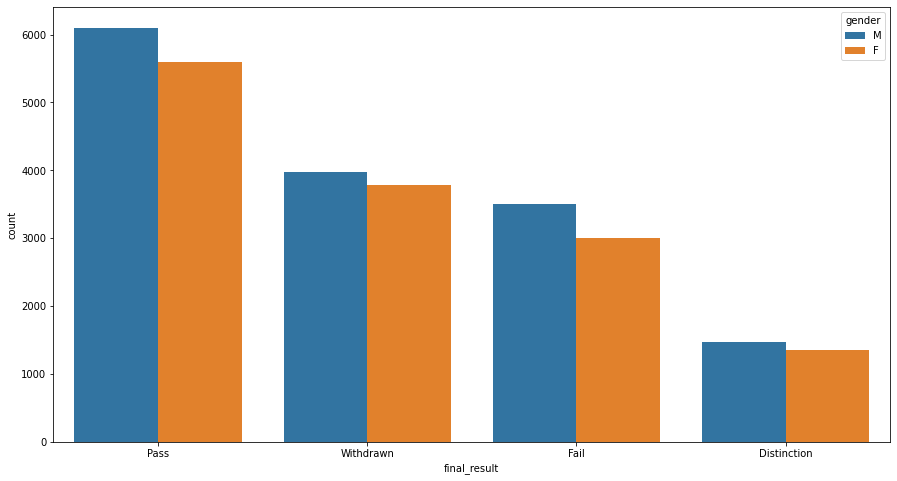

In [41]:
# Perform BA on gender vs final_result with a countplot
plt.figure(figsize=(15,8))
sns.countplot(x='final_result', hue='gender', data=studentInfo_Vle_Scores)

##Engineer New Features
This section involves dummification of the categorical variables.

We first note that '<' and '=' do not play well with certain models so we might as well replace all of the values in the age_band column first.

In [42]:
# Replace '55<='' in age_band to '55+'
studentInfo_Vle_Scores['age_band'] = studentInfo_Vle_Scores['age_band'].replace(['55<='],'55+')

In [43]:
# Declare a variable and store the dummified/one-hot encoded values from 'code_module'
code_module = pd.get_dummies(studentInfo_Vle_Scores['code_module'], drop_first=True)
code_module

,BBB,CCC,DDD,EEE,FFF,GGG
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
28780,0,0,0,0,0,1
28781,0,0,0,0,0,1
28782,0,0,0,0,0,1
28783,0,0,0,0,0,1


In [45]:
# Declare variables to store the dummified/one-hot encoded values from the other categorical variables
code_presentation = pd.get_dummies(studentInfo_Vle_Scores['code_presentation'], drop_first=True)
gender = pd.get_dummies(studentInfo_Vle_Scores['gender'], drop_first=True)
region = pd.get_dummies(studentInfo_Vle_Scores['region'], drop_first=True)
imd_band = pd.get_dummies(studentInfo_Vle_Scores['imd_band'], drop_first=True)
age_band = pd.get_dummies(studentInfo_Vle_Scores['age_band'], drop_first=True)
disability = pd.get_dummies(studentInfo_Vle_Scores['disability'], drop_first=True)


In [47]:
# Step 11: Concatenate every dummy dataframe into a single DataFrame
dummies = pd.concat([code_module, code_presentation, gender, region, imd_band, age_band, disability], axis=1)
dummies

,BBB,CCC,DDD,EEE,FFF,GGG,2013J,2014B,2014J,M,East Midlands Region,Ireland,London Region,North Region,North Western Region,Scotland,South East Region,South Region,South West Region,Wales,West Midlands Region,Yorkshire Region,10-20,20-30%,30-40%,40-50%,50-60%,60-70%,70-80%,80-90%,90-100%,Missing,35-55,55+,Y
0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28780,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
28781,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
28782,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
28783,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


Let's replace the 'final_result' values with 1 and 0 because we only have two outcomes in a programme - fail or pass.

Hence, we shall bin our categorical results like this:
- Pass/Distinction (1); 
- Withdrawn/Fail (0)

In [48]:
# Replace the categorical values in final_result
studentInfo_Vle_Scores['final_result'] = studentInfo_Vle_Scores['final_result'].replace(['Pass', 'Distinction'], 1)
studentInfo_Vle_Scores['final_result'] = studentInfo_Vle_Scores['final_result'].replace(['Withdrawn', 'Fail'], 0)

In [49]:
# Subset the original DataFrame
studentInfo_Vle_Scores = studentInfo_Vle_Scores[['num_of_prev_attempts', 'studied_credits', 'sum', 'mean', 'max', 'min', 'final_result']]

In [50]:
# Concatenate everything together
studentInfo_Vle_Scores_new = pd.concat([studentInfo_Vle_Scores, dummies], axis=1)
studentInfo_Vle_Scores_new

,num_of_prev_attempts,studied_credits,sum,mean,max,min,final_result,BBB,CCC,DDD,EEE,FFF,GGG,2013J,2014B,2014J,M,East Midlands Region,Ireland,London Region,North Region,North Western Region,Scotland,South East Region,South Region,South West Region,Wales,West Midlands Region,Yorkshire Region,10-20,20-30%,30-40%,40-50%,50-60%,60-70%,70-80%,80-90%,90-100%,Missing,35-55,55+,Y
0,0,240,934.0,82.000000,85.0,78.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,60,1435.0,66.400000,70.0,60.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,60,281.0,76.000000,94.0,59.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
3,0,60,2158.0,76.000000,88.0,71.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,60,1034.0,54.400000,75.0,30.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28780,0,30,41.0,76.000000,94.0,59.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
28781,0,30,893.0,88.111111,100.0,72.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
28782,0,30,312.0,76.666667,100.0,60.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
28783,0,30,275.0,91.500000,100.0,83.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0



##Apply machine learning techniques to train a model to predict student dropout

Generally, the machine learning process has five parts:

1. <strong> Split data into train and test set </strong> 
2. <strong> Model creation </strong> <br>
Import models from sklearn and instantiate them (assign model object to a variable)
3. <strong> Model fitting </strong> <br> 
Fit your training data into the model and train train train
4. <strong> Model prediction </strong> <br>
Make a set of predictions using your test data, and
5. <strong> Model assessment </strong> <br>
Compare your predictions with ground truth in test data

In [51]:
# Prepare indepedent and dependent variables
X = studentInfo_Vle_Scores_new.drop(columns=['final_result'])
y = studentInfo_Vle_Scores_new['final_result']

X.shape

(28785, 41)

In [52]:
# Import the machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix

In [53]:
# Split your data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [54]:
# Declare a variable to store dummy model
dummy_model = DummyClassifier()

# Fit your train dataset
dummy_model.fit(X_train, y_train)

# Declare a variable and store your predictions that you make with your model using X test data
dummy_model_pred = dummy_model.predict(X_test)

# Print the f1_score between y_test and your prediction
print(f'The f1_score is {f1_score(y_test, dummy_model_pred):0.2f}')

# Print the confusion matrix between y_test and your prediction
print('The confusion matrix is ')
confusion_matrix(y_test, dummy_model_pred)

The f1_score is 0.50
The confusion matrix is 


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


array([[1382, 1462],
       [1469, 1444]])

In [55]:
# Repeat the above steps for LogisticRegression
lr = LogisticRegression(n_jobs=-1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print(f'The f1_score is {f1_score(y_test, lr_pred):0.2f}')
print('The confusion matrix is ')
confusion_matrix(y_test, lr_pred)

The f1_score is 0.82
The confusion matrix is 


array([[2353,  491],
       [ 543, 2370]])

In [56]:
# Repeat the above steps for DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

print(f'The f1_score is {f1_score(y_test, dt_pred):0.2f}')
print('The confusion matrix is ')
confusion_matrix(y_test, dt_pred)

The f1_score is 0.82
The confusion matrix is 


array([[2341,  503],
       [ 537, 2376]])

In [57]:
# Repeat the above steps for RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state = 0)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print(f'The f1_score is {f1_score(y_test, rf_pred):0.2f}')
print('The confusion matrix is ')
confusion_matrix(y_test, rf_pred)

The f1_score is 0.85
The confusion matrix is 


array([[2385,  459],
       [ 413, 2500]])

In [58]:
# Now we try GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

print(f'The f1_score is {f1_score(y_test, clf_pred):0.2f}')
print('The confusion matrix is ')
confusion_matrix(y_test, clf_pred)

The f1_score is 0.87
The confusion matrix is 


array([[2320,  524],
       [ 259, 2654]])

In [59]:
# Create a DataFrame containing feature importances
feature_importance = list(zip(X_train.columns, clf.feature_importances_))
feature_importance.sort(key=lambda x: x[1], reverse=True)

feature_importance = pd.DataFrame(feature_importance, columns=['feature', 'importance'])
feature_importance.head(10)

,feature,importance
0,sum,0.730948
1,max,0.190213
2,FFF,0.026496
3,min,0.021827
4,mean,0.019414
5,2013J,0.001711
6,90-100%,0.001093
7,GGG,0.001085
8,35-55,0.001085
9,CCC,0.000997



So we have successfully implemented machine learning in predicting student dropout. Of course, we acknowledge there is (a lot more) room to improve for the model.